# Random forest model--48 hr lag

In [1]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
import glob
import os
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split


# 0. Loading data

In [2]:
bids_down = pd.read_csv("../data/as_bids_REGDOWN.csv")
bids_up = pd.read_csv("../data/as_bids_REGUP.csv")
prices = pd.read_csv("../data/AS_price_vol.csv")
plan = pd.read_csv("../data/as_plan.csv")
energy = pd.read_csv("../data/energy_price.csv")
weather = pd.read_csv("../data/weather_forecast_ercot.csv")
gen = pd.read_csv("../data/generation.csv")
wind = pd.read_csv("../data/wind.csv")

A bit more data cleaning

In [3]:
#generation
gen['hr_beg'] = gen['hr_beg'].apply(lambda x: x[0:2]) 
gen.drop(columns=['Imports','Other','ST'], inplace=True)

gen['year'] = pd.to_datetime(gen['date']).dt.year
gen = gen.loc[gen['year']>2011,:]
gen.reset_index(inplace=True, drop=True)
gen.drop(columns=['year'], inplace=True)

In [4]:
#energy
energy.drop_duplicates(subset=['date','hr_beg'], inplace=True)

In [5]:
#wind
wind.drop(columns=['ACTUAL_SYSTEM_WIDE'], inplace=True)

In [6]:
data_frames = [bids_down, bids_up, prices, plan, energy, weather, gen, wind]

for i,df in enumerate(data_frames):
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['hr_beg'] = df['hr_beg'].astype(int)
    df.sort_values(by=['date','hr_beg'], inplace=True)
    df.drop_duplicates(inplace=True)

In [7]:
union = prices.merge(bids_down, how='inner', on=['date','hr_beg'])
for dd in [bids_up, plan, energy, weather, gen, wind]:
    union = union.merge(dd, how='inner', on=['date','hr_beg'])

In [8]:
#dealing with NAs
union.fillna(method='bfill',axis=0, inplace=True)
union.sort_values(by=['date','hr_beg'], inplace=True)

### Processing features

In [9]:
#Setting spike at 90th percentile price for pre-2018 data
spike = np.percentile(union['price_DAH_REGDN'][union['date'] < datetime.date(2018,1,1)], 90)
spike

13.17

In [10]:
cut_labels = ['regular', 'spike']
cut_bins = [0, spike, 1000]
union['cuts'] = pd.cut(union['price_DAH_REGDN'], bins=cut_bins, labels=cut_labels)

In [11]:
#manually dropping correlated columns
union.drop(columns = ['price_DAH_busavg','price_DAH_N', 'price_DAH_S', 'price_DAH_W',
                      'price_RT15_houston','price_RT15_busavg','price_RT15_houston',
                     'price_RT15_N', 'price_RT15_S', 'price_RT15_W','NorthCentral', 'SouthCentral',
                      'Southern', 'West','ramp_abs','80th Pctl Bid_REGUP','80th Pctl Bid',
                      '60th Pctl Bid_REGUP','60th Pctl Bid'], inplace=True)

In [12]:
#adding in weekday/weekend
union['dt'] = pd.to_datetime(union['date'].astype(str) + " " + union['hr_beg'].astype(str)+ ":00")

#converting back to central time
import pytz
from pytz import timezone
utc = timezone('UTC')
union['UTC'] = union['dt'].apply(lambda x: utc.localize(x))
tz = timezone('America/Chicago')
union['Central'] = union['UTC'].apply(lambda x: x.astimezone(tz))
union['hr_central'] = union['Central'].dt.hour
union['date_central'] = union['Central'].dt.date
union['year'] = union['Central'].dt.year

#weekends vs weekdays
union['weekday_number'] = union['date_central'].apply(lambda x: x.weekday())
union['weekend'] = 0
union['weekday'] = 0
union['weekend'][union['weekday_number'].isin([5,6])] = 1
union['weekday'][union['weekday_number'].isin([0,1,2,3,4])] = 1

union.drop(columns=['dt','Central','UTC','weekday_number','hr_beg','date'], inplace=True)

In [13]:
def lag_and_concat(union, tar='cuts'):
    #separating features that are forecasts, and can be used as-is, and those that have to be lagged
    realtime = ['date_central','year','Coast', 'East', 'FarWest', 'North', 'NSPIN_Quantity', 'REGDN_Quantity',
                'REGUP_Quantity', 'RRS_Quantity', 'STWPF_SYSTEM_WIDE', 'weekend', 'weekday'] #'West','NorthCentral', 'SouthCentral', 'Southern', 
    lagged = list(set(union.columns) - set(realtime + [tar] + ['cuts']))

    features_realtime = union[realtime]
    features_lagged = union[lagged]
    target = union[tar]
    
    #shifting lagged features by 48, and 72 hours

    y = features_lagged.shift(48)
    y.columns = y.columns+"_48"

    z =  features_lagged.shift(72)
    z.columns = z.columns+"_72"

    #concatenating
    new = pd.concat([y,z,features_realtime,target], axis=1)
    new = new.dropna()

    new.drop(columns=['hr_central_48'], inplace=True) 
    
    return new

# 1. RF Model

In [14]:
new = lag_and_concat(union)

In [15]:
X = new[new['year']<2018].drop(columns=['cuts','date_central'])
X_test = new[new['year']==2018].drop(columns=['cuts','date_central'])
y = new.loc[new['year']<2018,'cuts']
y_test = new.loc[new['year']==2018,'cuts']

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)

rf_tree = RandomForestClassifier(random_state=42)
rf_tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [16]:
def model_performance(rf_tree, X_test, y_test):
    """
    Takes RF tree, test X's, test y's
    Returns percentage of spikes and overall hours correctly predicted
    """
    
    y_pred = rf_tree.predict(X_test)
    results = pd.DataFrame({"pred": y_pred, 
                            "test": y_test, 
                            "correct_spike": (y_pred == y_test) & (y_test == 'spike'),
                           "correct_regular": (y_pred == y_test) & (y_test == 'regular')})
    correct_spikes = sum(results['correct_spike'])/sum(results['test']=='spike')
    correct_overall = (sum(results['correct_spike']) + sum(results['correct_regular']))/len(results)
    
    return correct_spikes, correct_overall

In [17]:
##Training (validation) score -- for model selection
c_val, o_val = model_performance(rf_tree, X_val, y_val)
print("TRAINING")
print("Spikes correctly predicted: " + str(c_val))
print("Overall hours correctly predicted: " + str(o_val))

##Testing score
c_test, o_test = model_performance(rf_tree, X_test, y_test)
print("TESTING")
print("Spikes correctly predicted: " + str(c_test))
print("Overall hours correctly predicted: " + str(o_test))

TRAINING
Spikes correctly predicted: 0.4838709677419355
Overall hours correctly predicted: 0.9381514145000572
TESTING
Spikes correctly predicted: 0.31422505307855625
Overall hours correctly predicted: 0.9569585569128896


In [18]:
#relative feature importance
def rel_feat_imp(rf_tree):
    feature_importance = rf_tree.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feats = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance}).sort_values(by='importance', ascending=False).head(15)
    return feats

In [19]:
rel_feat_imp(rf_tree).head(5)

,feature,importance
12,price_DAH_REGDN_48,100.000000
52,price_DAH_REGDN_72,64.796955
88,STWPF_SYSTEM_WIDE,56.508073
85,REGDN_Quantity,43.823547
23,vol_DAH_REGDN_48,34.499971


# 2. Engineering new features
Predicting load, net load, coal, and NGCC generation for target hour. Also adding in average hourly price. Testing random forest vs OLS/lasso; using MSE because we're trying to predict continuous variable. RMSE for RF was ~500 MW, whereas for Ridge/OLS it was ~2000 at all values of alpha from -10-10.

In [20]:
def feature_maker(tar):
    """
    tar: column name in union df that is the variable you want to predict
    depends on union df existing
    """
    #create 
    new = lag_and_concat(union, tar=tar)
    
    X = new[new['year']<2018].drop(columns=['date_central',tar])
    X_test = new[new['year']==2018].drop(columns=['date_central',tar])
    y = new.loc[new['year']<2018,tar]
    y_test = new.loc[new['year']==2018,tar]

    # split between train and validation sets; fit tree on training data
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)
    rf_tree = RandomForestRegressor(random_state=42)
    rf_tree.fit(X_train, y_train)
    
    # using tree to predict variable across all training, validation, and testing data
    y_pred_train = rf_tree.predict(X) 
    y_pred_test = rf_tree.predict(X_test)
    Predicted_Var = np.concatenate([y_pred_train, y_pred_test])

    pred_df = new[['date_central','hr_central_72']][new['year']<2019]
    pred_df['Predicted_'+tar] = Predicted_Var
    
    return pred_df

### Predicting load

In [21]:
Predicted_Load = feature_maker('Load.MW')

### Predicting NGCC gen

In [22]:
Predicted_NGCC = feature_maker('NGCC')

### Predicting coal gen

In [23]:
Predicted_Coal = feature_maker("Coal")

### Predicting net load

In [24]:
Predicted_Netload = feature_maker("load_net")

### Average hourly price

In [25]:
averages = union[['price_DAH_REGDN','hr_central']].groupby('hr_central').mean().to_dict()['price_DAH_REGDN']

### Adding engineered features

In [26]:
new_engineered = lag_and_concat(union)

In [27]:
Predicted_Load.drop_duplicates(subset=['date_central','hr_central_72'], inplace=True)
Predicted_NGCC.drop_duplicates(subset=['date_central','hr_central_72'], inplace=True)
Predicted_Coal.drop_duplicates(subset=['date_central','hr_central_72'], inplace=True)
Predicted_Netload.drop_duplicates(subset=['date_central','hr_central_72'], inplace=True)

In [28]:
new_engineered.shape

(43680, 93)

In [29]:
#adding engineered features
new_engineered = new_engineered.merge(Predicted_Load, how="left", on=['date_central','hr_central_72'])
new_engineered = new_engineered.merge(Predicted_NGCC, how="left", on=['date_central','hr_central_72'])
new_engineered = new_engineered.merge(Predicted_Coal, how="left", on=['date_central','hr_central_72'])
new_engineered = new_engineered.merge(Predicted_Netload, how="left", on=['date_central','hr_central_72'])

#adding averages
new_engineered['AveragePrice'] = new_engineered['hr_central_72'].map(averages)

In [30]:
new_engineered.shape

(43680, 98)

In [33]:
X = new_engineered[new_engineered['year']<2018].drop(columns=['cuts','date_central'])
X_test = new_engineered[new_engineered['year']==2018].drop(columns=['cuts','date_central'])
y = new_engineered.loc[new_engineered['year']<2018,'cuts']
y_test = new_engineered.loc[new_engineered['year']==2018,'cuts']

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)

rf_tree = RandomForestClassifier(random_state=42)
rf_tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
##Training (validation) score -- for model selection
c_val, o_val = model_performance(rf_tree, X_val, y_val)
print("TRAINING")
print("Spikes correctly predicted: " + str(c_val))
print("Overall hours correctly predicted: " + str(o_val))

##Testing score
c_test, o_test = model_performance(rf_tree, X_test, y_test)
print("TESTING")
print("Spikes correctly predicted: " + str(c_test))
print("Overall hours correctly predicted: " + str(o_test))

TRAINING
Spikes correctly predicted: 0.5195852534562212
Overall hours correctly predicted: 0.9402130340167221
TESTING
Spikes correctly predicted: 0.34182590233545646
Overall hours correctly predicted: 0.9554743692202307


In [35]:
feats = rel_feat_imp(rf_tree)
feats.head(5)

,feature,importance
12,price_DAH_REGDN_48,100.000000
92,Predicted_NGCC,73.766758
52,price_DAH_REGDN_72,53.904780
94,Predicted_load_net,53.355879
85,REGDN_Quantity,42.828526


# 3. Model with downselected features

In [36]:
#from sklearn.feature_selection import RFECV
#selector = RFECV(rf_tree, step=1, cv=5)
#selector = selector.fit(X_train, y_train) -- would be ideal, but takes too much time
#selector.ranking_

In [39]:
features = feats['feature']
simpler = new_engineered.loc[:,features[:20]]
simpler['cuts'] = new_engineered['cuts']
simpler['year'] = new_engineered['year']

In [40]:
X = simpler[simpler['year']<2018].drop(columns=['cuts'])
X_test = simpler[simpler['year']==2018].drop(columns=['cuts'])
y = simpler.loc[simpler['year']<2018,'cuts']
y_test = simpler.loc[simpler['year']==2018,'cuts']

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)
rf_tree = RandomForestClassifier(random_state=42)
rf_tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [41]:
##Training (validation) score -- for model selection
c_val, o_val = model_performance(rf_tree, X_val, y_val)
print("TRAINING")
print("Spikes correctly predicted: " + str(c_val))
print("Overall hours correctly predicted: " + str(o_val))

##Testing score
c_test, o_test = model_performance(rf_tree, X_test, y_test)
print("TESTING")
print("Spikes correctly predicted: " + str(c_test))
print("Overall hours correctly predicted: " + str(o_test))

TRAINING
Spikes correctly predicted: 0.5276497695852534
Overall hours correctly predicted: 0.93643339823617
TESTING
Spikes correctly predicted: 0.4607218683651805
Overall hours correctly predicted: 0.9562735472085855


In [42]:
rel_feat_imp(rf_tree).head(5)

,feature,importance
0,price_DAH_REGDN_48,100.000000
1,Predicted_NGCC,82.746385
2,price_DAH_REGDN_72,70.025002
3,Predicted_load_net,55.636740
4,REGDN_Quantity,48.043331


# Tuning hyperparameters
Could use grid search, but dataset far too big

In [295]:
from sklearn.model_selection import validation_curve

In [299]:
#1. testing number of estimators (number of trees in the forest; default = 100...changed from 10)
num_est = [1,2,4,8,16,32,64,128,256]
train_scores, valid_score = validation_curve(RandomForestClassifier(),
                                X, y, param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

Text(0.5, 1.0, 'n_estimators')

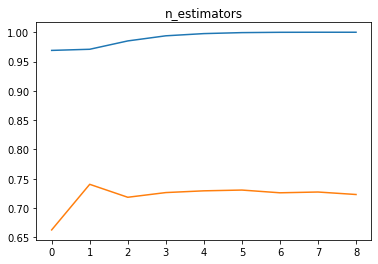

In [314]:
plt.plot(train_scores.mean(axis=1), label="train")
plt.plot(valid_score.mean(axis=1), label="valid")
plt.title('n_estimators')

In [315]:
#2. testing max_depth (default: none)
num_est = [5,10,15,20,25,30]
train_scores, valid_score = validation_curve(RandomForestClassifier(),
                                X, y, param_name = 'max_depth', 
                                param_range = num_est, cv = 3)

Text(0.5, 1.0, 'max_depth')

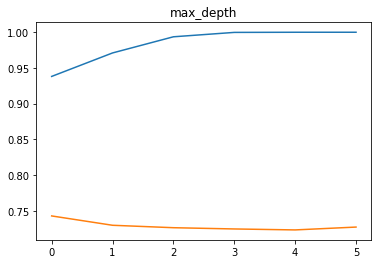

In [316]:
plt.plot(train_scores.mean(axis=1), label="train")
plt.plot(valid_score.mean(axis=1), label="valid")
plt.title('max_depth')

In [317]:
#3. testing min_samples_split (default: 2)
num_est = [1,2,5,10,15]
train_scores, valid_score = validation_curve(RandomForestClassifier(),
                                X, y, param_name = 'min_samples_split', 
                                param_range = num_est, cv = 3)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

Text(0.5, 1.0, 'min_samples_split')

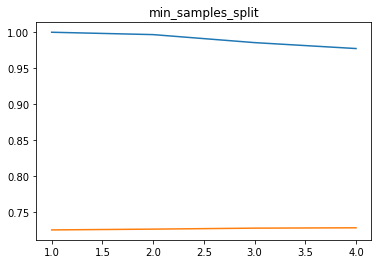

In [318]:
plt.plot(train_scores.mean(axis=1), label="train")
plt.plot(valid_score.mean(axis=1), label="valid")
plt.title('min_samples_split')

In [319]:
#4. min_samples_leaf (default: 1)
num_est = [1,2,5,10,15]
train_scores, valid_score = validation_curve(RandomForestClassifier(),
                                X, y, param_name = 'min_samples_leaf', 
                                param_range = num_est, cv = 3)

Text(0.5, 1.0, 'min_samples_leaf')

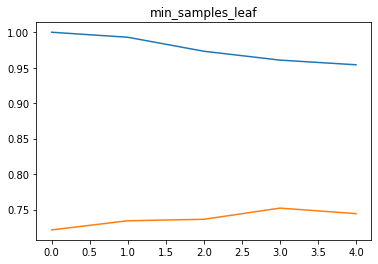

In [320]:
plt.plot(train_scores.mean(axis=1), label="train")
plt.plot(valid_score.mean(axis=1), label="valid")
plt.title('min_samples_leaf')

In [322]:
#5. max_features (default = auto (sqrt of n_features))
num_est = [1,2,3,4,6,8,10]
train_scores, valid_score = validation_curve(RandomForestClassifier(),
                                X, y, param_name = 'max_features', 
                                param_range = num_est, cv = 3)

Text(0.5, 1.0, 'max_features')

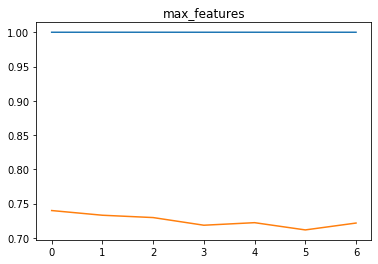

In [323]:
plt.plot(train_scores.mean(axis=1), label="train")
plt.plot(valid_score.mean(axis=1), label="valid")
plt.title('max_features')

In [342]:
#Abbreviated grid search -- this may be misleading bc better accuracy can accrute to non-spikes
from sklearn.model_selection import GridSearchCV

n_estimators = [75, 100, 150, 200]
min_samples_leaf = [1,2,4] 
max_features = [3,4,8]

param_dict = dict(n_estimators = n_estimators, 
              min_samples_leaf = min_samples_leaf, max_features = max_features)

grid_forest = GridSearchCV(RandomForestClassifier(random_state=42), param_dict, cv = 3, verbose = 1, 
                      n_jobs = -1)
best_forest = grid_forest.fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  9.0min finished


In [344]:
##Testing score
c_test, o_test = model_performance(best_forest, X_test, y_test)
print("TESTING")
print("Spikes correctly predicted: " + str(c_test))
print("Overall hours correctly predicted: " + str(o_test))

TESTING
Spikes correctly predicted: 0.46709129511677283
Overall hours correctly predicted: 0.9593560908779541


# 4. Exporting results for optimization team
Missing last hour of the year; filling with second-to-last

In [43]:
results = union.loc[union['year']==2018,['date_central','hr_central','price_DAH_REGDN']]
results.reset_index(inplace=True, drop=True)
assert len(results) == 8759

In [44]:
results.rename(columns={'price_DAH_REGDN':'Actual_REGDN_Price'}, inplace=True)
results['Actual_Category'] = y_test
results['Predicted_Category'] = rf_tree.predict(X_test)

In [45]:
#Assigning hourly average for regular hours, and spike average for spiky hours
regular_hours = union[['date_central','hr_central','price_DAH_REGDN']][(union['price_DAH_REGDN']<spike) & 
                                                           (union['year']<2018)]
spike_hours = union[['date_central','hr_central','price_DAH_REGDN']][(union['price_DAH_REGDN']>=spike) & 
                                                           (union['year']<2018)]

avgs = regular_hours.groupby('hr_central').mean().to_dict()
spike_avg = spike_hours['price_DAH_REGDN'].mean()

results['Predicted_Price'] = results['hr_central'].map(avgs['price_DAH_REGDN'])
results['Predicted_Price'][results['Predicted_Category']=='spike'] = spike_avg

In [46]:
temp = pd.DataFrame(results[-1:].values, index=[8759], columns=results.columns)
temp.loc[8759,'hr_central'] = 18
results = results.append(temp)

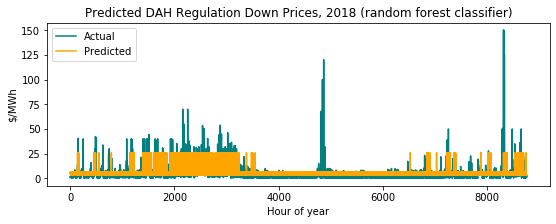

In [47]:
fig = plt.figure(figsize=(9,3))
plt.plot(results['Actual_REGDN_Price'], label="Actual", color='teal')
plt.plot(results['Predicted_Price'], label="Predicted", color='orange')
plt.legend()
plt.title("Predicted DAH Regulation Down Prices, 2018 (random forest classifier)")
plt.xlabel('Hour of year')
plt.ylabel("$/MWh")
plt.savefig("Random_Forest_Results_48.png")

results.to_csv("random_forest_results_48.csv", index=False)